# Ensemble Methods

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge

Last Update 04/22/2022

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Random Trials - The Coin Toss Game

There is a simple powerful way to conceptualize the power of repeated random trails.  It is expressed as a betting game and understanding this setup will help below when thinking about how a weak algorithm run repeatedly can yield a strong algorithm. 

Here is the game.  I tell you I have an unfair (to me) coin.  It comes up heads only one out of six times. So, formally

$$
P(toss=heads) = \frac{1}{6}
$$

You pay me \\$1 if my unfair coin comes heads at least once in four tosses, otherwise I pay you \\$1.

Presuming I get you to play - a lot - then who ends up winning money?

To work this out first realize that the only way I loose is if the coin fails to come up heads in all four tosses. 

To begin working out the probability I loose, consider the simpler case that I fail on a given toss. This is just the probability of tails on that toss. 



$$
P(toss=tails) = 1 - P(toss=heads) = \frac{5}{6}
$$

To fail on each and every of the four tosses the event $P(toss=tails)$ must happen on each toss. Since that consitutes Failure (for me) and we will write it $P_{F}$: 

$$
P_{F} = P(toss=tails)^4  = \left( \frac{5}{6} \right)^4 = \frac{625}{1296} = 0.483
$$

So in expectation I fail (loose) $483$ out of every $1,000$ games. But wait, I am starting to feel better about this game. Even though my coin comes up heads relatively rarely, by using four repeated tosses, my probabiliy of winning is better than $50$/$50$. It is $0.517$ to be precise. Over time I win!

## Power of Repeated Trials

Now let us generalize this coin toss game and consider what happens if we can spend compute time to increase our odds of succeeding.  The question is this. If we have an algorithm that successfully solves a problem with probability $p_s$ and $p_s$ is a relatively small number, then how many indepdent trials (flips) are required to ensure seeing success at least once.

The math looks like the following, for $k$ trials the probability of failing on all $k$ trials is:

$$
P_{F} = \left( 1 - p_{s} \right)^k
$$

And since success is the opposite of failure, the probability of success over $k$ trials is

$$
P_{S} = 1 - P_{F} = 1 - \left( 1 - p_{s} \right)^k
$$

The following code shows what this looks like using an algorithm which succeeds one out of ten times and is run for different numbers of trials. Note the extremely high probability of success for even modest - by computer standards - numbers of trails. 

In [23]:
stps = 1 / 100   # Single Trial Probability of Success
trials = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
for k in trials :
    PS = 1 - (1 - stps)**k
    print(f'k = {k} the PS equal {PS:6.3f}')

k = 1 the PS equal  0.010
k = 2 the PS equal  0.020
k = 4 the PS equal  0.039
k = 8 the PS equal  0.077
k = 16 the PS equal  0.149
k = 32 the PS equal  0.275
k = 64 the PS equal  0.474
k = 128 the PS equal  0.724
k = 256 the PS equal  0.924
k = 512 the PS equal  0.994


In this example note how the critical factor is the probabiliyt of success/failure on a given trial is independent of the other trials, and consquently  something which is a rare event on any given trial, success, can become almost inevitable at least once in a set of trials.

Now as we move onto the ensemble methods, and in particular voting, the details change. However, the underlying fact that combining many weak answer can result in a single very reliable answer still holds true.

## IID Mistakes and Voting


Ensemble methods are machine learning methods that base their predictions on a collection of classifiers.  Each individual classifier might not have high accuracy, but by taking a "vote" among a diverse set, it is possible to obtain much higher accuracy than that of any member of the ensemble.
This idea can be traced all the way back to the work of British scientist Sir Francis Galton.
He discovered in the early 1900s that a collection of educated guesses can add up to very accurate predictions.
This has been termed as **the wisdom of crowds**, and was described in the following publication:

> Francis Galton. [Vox Populi](http://galton.org/essays/1900-1911/galton-1907-vox-populi.pdf).  Nature 75, pages 450-451, 1907.

Our intuition of why this works is that averaging of many independent and diverse measurements can lead to more reliable estimates.  The central limit theorem in statistics is a mathematical statement of that fact.

Let us illustrate the potential benefit of this diea by a simulation study.  Let's consider a set of five classifiers, each of which is right 70% of the time and see how voting increases accuracy.


In [3]:
# the following example inspired by code from
# http://ethen8181.github.io/machine-learning/trees/random_forest.html

from numpy.random import default_rng
rng = default_rng()
y = rng.choice([0,1], size=(1000,))

psont = 0.7
num_classifiers = 13
predictions_lst = []
for i in range(num_classifiers):
    outcome = [y[i] if rng.random()>(1-psont) else 1-y[i] for i in range(len(y))]
    predictions_lst.append(outcome)
predictions = np.array(predictions_lst)    

In [4]:
print(predictions[0,0:25])
print(y[0:25])

[1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0]
[1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0]


At this point `y` represents ground truth for some problem, i.e. the correct answer for each of $1000$ samples is either zero or one as shown in `y`.  Next, there are five instances of errorful predictions stored in the array `predictions`. Just to be clear, the next code counts how often the first (index zero) classifier got the correct answer.

In [5]:
foo = np.sum(predictions[0] == y)
print(f'First classifier got {foo} out of 1,000 correct')

First classifier got 674 out of 1,000 correct


Accross the five classifiers one sees a pattern where accuracy is hovering around $\frac{7}{10}$. Go back and review how the noisy label `y` estimates are created and this outcome should be completely predicatble.

In [6]:
# accuracy of individual classifiers:
for i in range(num_classifiers):
    print(f'Classifier {i} \taccuracy {np.mean(predictions[i] == y):5.3f}')

Classifier 0 	accuracy 0.674
Classifier 1 	accuracy 0.696
Classifier 2 	accuracy 0.677
Classifier 3 	accuracy 0.666
Classifier 4 	accuracy 0.690
Classifier 5 	accuracy 0.725
Classifier 6 	accuracy 0.692
Classifier 7 	accuracy 0.698
Classifier 8 	accuracy 0.691
Classifier 9 	accuracy 0.696
Classifier 10 	accuracy 0.680
Classifier 11 	accuracy 0.723
Classifier 12 	accuracy 0.724


### A Closer look at Voting

Now consider letting each of the five classifiers cast one vote in favor of either $1$ or $0$.

In [7]:
votes = np.sum(predictions, axis=0)
for i in range(16) :
    wins = np.round( np.sum(predictions[:,i]) / num_classifiers)
    print(f'Sample {i} true value \t {y[i]}: \tpredictions {predictions[:,i]} \t {votes[i]}\t{wins}')

Sample 0 true value 	 1: 	predictions [1 0 1 0 1 0 0 1 1 1 1 0 1] 	 8	1.0
Sample 1 true value 	 0: 	predictions [0 0 0 0 1 1 0 1 0 0 0 0 0] 	 3	0.0
Sample 2 true value 	 1: 	predictions [0 1 0 0 1 1 1 1 0 0 1 1 0] 	 7	1.0
Sample 3 true value 	 0: 	predictions [0 0 0 0 0 0 0 0 0 0 0 0 0] 	 0	0.0
Sample 4 true value 	 0: 	predictions [0 0 1 0 1 0 0 0 0 1 1 0 0] 	 4	0.0
Sample 5 true value 	 1: 	predictions [1 1 1 0 0 1 1 0 1 1 0 1 1] 	 9	1.0
Sample 6 true value 	 1: 	predictions [1 1 0 1 1 1 1 1 1 1 0 0 1] 	 10	1.0
Sample 7 true value 	 1: 	predictions [1 0 1 1 1 1 1 1 1 0 1 1 1] 	 11	1.0
Sample 8 true value 	 1: 	predictions [1 0 1 1 1 0 1 1 0 1 0 1 1] 	 9	1.0
Sample 9 true value 	 0: 	predictions [0 0 1 1 0 0 0 0 1 1 1 0 0] 	 5	0.0
Sample 10 true value 	 0: 	predictions [0 0 0 0 1 0 1 0 0 0 1 1 0] 	 4	0.0
Sample 11 true value 	 0: 	predictions [0 0 1 0 1 0 1 0 0 0 0 0 0] 	 3	0.0
Sample 12 true value 	 1: 	predictions [1 1 0 1 0 0 1 1 1 0 1 1 1] 	 9	1.0
Sample 13 true value 	 1: 	predic

Put it all together and note how much better this ensemble of classifiers does at predicting the true labels.

In [8]:
# accuracy of the voted classifier:
ensemble_predictions = np.round(np.sum(predictions, axis=0) / num_classifiers)
np.mean(ensemble_predictions == y)

0.947

Note that the accuracy increases as the number of models increases.
This result is an example of the [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).
This idea can be applied for real machine learning problems.  All we need is an **ensemble of diverse models from the same training data**.  We will discuss several ways of achieving this goal.  The general strategy for constructing ensemble classifiers is as follows:

* Construct a collection of diverse predictive models by tweaking the training data
* Combine the predictions of the models, e.g. by voting

The simplest implementation of this idea is through the strategy known as "bagging", which is described next.

### Bagging

Bagging (**b**ootstrap **agg**regat**ing**) is a simple ensemble method based on the concept of a **bootstrap sample**.

**Bootstrap sample:**  a sample with replacement from a dataset.

For example:

In [9]:
sample = rng.choice(range(10), size=(10), replace=True)
sample

array([1, 4, 6, 4, 3, 5, 4, 1, 2, 2])

In a bootstrap sample, the probability that a given example is not selected when taking a bootstrap sample of size $N$ is $(1 - \frac{1}{N})^N$.  This has a limit as $N$ goes to infinity which is equal to 
$1/e = 0.368$.  From this observation we can conclude that each bootstrap sample is likely to leave out about a third of the examples.


**Bagging** ($\mathcal{D}$, $\mathcal{A}$, $T$)

Input:  labeled dataset $\mathcal{D}$, learning algorithm $\mathcal{A}$, ensemble size $T$.

Output:  ensemble of models whose predictions are combined by voting/averaging

* for $t = 1,...,T$

* build bootstrap sample $\mathcal{D}_t$ by sampling $N$ data points with replacement from $\mathcal{D}$
* train $\mathcal{A}$ on $\mathcal{D}_t$ to produce a model $\mathcal{M}_t$.

return $\mathcal{M}_1,\ldots,\mathcal{M}_T$.

The algorithm was described in the following publication:

> Breiman, Leo (1996). "Bagging predictors”. Machine Learning 24 (2): 123–140.


### Quick Empirical Look at Claim

Here, and often, it is useful to use empirical simulation to develop intuition in support of an analytical result. The analysis just presented is to me, at least, surprising. Namely, that roughly four out of every ten possible instances (values) will be omitted when sampling with replacement. So, just to kind of **see** what is happening, here is a simulation of the overall process 

In [10]:
num_values = 16
bag_size = num_values
num_draws = 8
draws_lst = []
for i in range(num_draws) :
    bag = rng.choice(range(num_values), size=(bag_size), replace=True)
    draws_lst.append(bag)
draws = np.array(draws_lst)
miss_lst = []
for i in range(num_draws) :
    cisin = np.isin(range(num_values), draws[i])
    pmiss = np.round(1.0 - np.sum(cisin)/num_values,2)
    miss_lst.append(pmiss)
    print(f'Draw {i} is {draws[i]}\tPercent Missing: {pmiss}')
mean_miss = np.mean(np.array(miss_lst))
print(f'Average percent missed is {mean_miss}')

Draw 0 is [ 8 10  6  7  4 15 11 10  6  4  6  9  1  1 11 14]	Percent Missing: 0.38
Draw 1 is [13  4 15 13  7  6 11  8 13 14 13  7 10 12  7 12]	Percent Missing: 0.38
Draw 2 is [ 6 14 10 15 14  3 15 14  3 11  4 15  1 15  7  1]	Percent Missing: 0.44
Draw 3 is [ 2 15  6  1  4  2  5 10  8  1  6  9 15 12  2  1]	Percent Missing: 0.38
Draw 4 is [12  6 15 10  3 13  3  3  9 13  2 14  4  6 14  6]	Percent Missing: 0.38
Draw 5 is [11  1  3  6  1 13 10  0  4  5  1  1  5  7 15  7]	Percent Missing: 0.31
Draw 6 is [ 1 15  0 13  8  2  9  4 12  0  5 10  7 14  1  2]	Percent Missing: 0.19
Draw 7 is [13 14 15 13 14  7 10  6  1  3  5  6  9  4  4  5]	Percent Missing: 0.31
Average percent missed is 0.34625


Here is almost the same code but this time we sort the selected integers making it much easier to count quickly the missing integers.

In [11]:
num_values = 16
bag_size = num_values
num_draws = 8
draws_lst = []
for i in range(num_draws) :
    bag = rng.choice(range(num_values), size=(bag_size), replace=True)
    bag.sort()
    draws_lst.append(bag)
draws = np.array(draws_lst)
miss_lst = []
for i in range(num_draws) :
    cisin = np.isin(range(num_values), draws[i])
    pmiss = np.round(1.0 - np.sum(cisin)/num_values,2)
    miss_lst.append(pmiss)
    print(f'Draw {i} is {draws[i]}\tPercent Missing: {pmiss}')
mean_miss = np.mean(np.array(miss_lst))
print(f'Average percent missed is {mean_miss}')

Draw 0 is [ 0  0  2  2  2  2  4  5  5  6  6  8  8  9  9 14]	Percent Missing: 0.5
Draw 1 is [ 0  0  0  1  2  2  2  4  7  8  8  9 12 13 14 14]	Percent Missing: 0.38
Draw 2 is [ 1  2  5  5  6  7  7  7  8  8  8  8 10 10 12 13]	Percent Missing: 0.44
Draw 3 is [ 0  0  1  1  1  5  6  7  8  9  9 12 12 13 13 14]	Percent Missing: 0.38
Draw 4 is [ 0  1  1  1  2  2  3  6  6  7  9  9 10 12 12 13]	Percent Missing: 0.38
Draw 5 is [ 0  1  2  4  4  4  4  4  6  8  8  9  9 12 13 15]	Percent Missing: 0.38
Draw 6 is [ 1  5  6  7  7  9 10 11 12 12 12 13 13 15 15 15]	Percent Missing: 0.38
Draw 7 is [ 1  2  3  6  7  9 10 11 12 13 13 14 14 14 15 15]	Percent Missing: 0.25
Average percent missed is 0.38625000000000004


### Random forests

Random forests are a special case of bagging with the following additional features:
* Use decision trees as the base classifier
* At each split in the decision tree, choose a subset of features from which to choose the split on.

As we discussed, decision trees can be unstable with respect to perturbations of the training data.  This is not a desirable property from a learning algorithm, but is actually useful as a component in an ensemble classifier.
Sampling the features serves to further increase the diversity of the resulting classifiers.  

<img style="padding: 10px; float:center;" alt="CC BY-SA 4.0
 by Venkata Jagannath - https://community.tibco.com/wiki/random-forest-template-tibco-spotfirer-wiki-page" src="https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png" width="300">



**Random Forests** ($\mathcal{D}$, $T$, num_features)

Input:  labeled dataset $\mathcal{D}$, ensemble size $T$, and num_features, the number of features to sample for each tree.

Output:  ensemble of models whose predictions are combined by voting/averaging

* for $t = 1,...,T$

* build bootstrap sample $\mathcal{D}_t$ by sampling $N$ data points with replacement from $\mathcal{D}$
* train a decision tree on $\mathcal{D}_t$ where each split is chosen on the basis of `num_features` random features; produce a model $\mathcal{M}_t$.

return $\mathcal{M}_1,\ldots,\mathcal{M}_T$.

Random forests is one of the most important methods in machine learning.  The method was described in the following publication:


> Random forests.  L Breiman.  Machine Learning, 2001.

As a first step, we will explore the shape of the decision boundary of random forests and compare it to that of decision trees.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [13]:
def visualize_classifier(model, X, y, ax=None, cmap='viridis'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, alpha=0.6, zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)


In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
features = [0,1]
X = iris.data[:, features]
y = iris.target

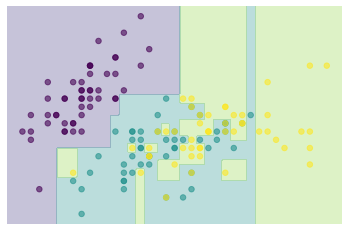

In [15]:
tree = DecisionTreeClassifier()
visualize_classifier(tree, X, y)

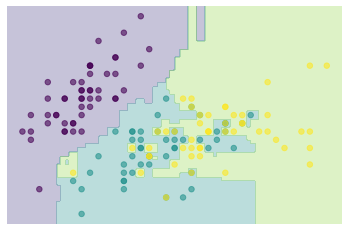

In [16]:
rf = RandomForestClassifier()
visualize_classifier(rf, X, y)

### Accuracy comparison of random forests and decision trees

We will demonstrate the accuracy advantage of random forests using a dataset whose number of features is larger than the number of training examples.  This is very common in biological datasets. The dataset describes the activity of a large number of genes, from which disease state can be inferred.  The particular dataset we will analyze looks at biological samples taken from leukemia patients with two types of leukemia: acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).  The data was taken from the following publication:

> Golub, Todd R., et al. "Molecular classification of cancer: class discovery and class prediction by gene expression monitoring." Science  (1999): 531-537.

In [17]:
import requests
# if you don't have requests installed you can use urlopen which is part
# of the python standard library
# from urllib.request import urlopen

link = "https://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv"
# retrieve the contents of the file
contents = requests.get(link)

In [18]:
lines = contents.text.split()
# the data is in csv format and the labels appear in the first 
# row of the dataset:
print (lines[0])
class_convert = {'ALL':1, 'AML':0}
y = np.array([class_convert[token] for token in lines[0].split(',')])
X = np.array([ [float(token) for token in line.split(',')] 
              for line in lines[1:] ])
X = X.transpose()
X.shape,y.shape

ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML,AML


((72, 7128), (72,))

In [19]:
classifier = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
accuracy = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
np.mean(accuracy)

0.7771428571428571

In [20]:
accuracy

array([0.86666667, 0.73333333, 0.78571429, 0.71428571, 0.78571429])

Next, let us apply random forests and observe the improvment in accuracy:

In [21]:
classifier = RandomForestClassifier(n_estimators=100)

accuracy = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
np.mean(accuracy)

0.9723809523809525

As you can see from our next experiment, random forests works better than bagging on this dataset:

In [22]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(DecisionTreeClassifier(), 
                        n_estimators=100)
accuracy = cross_val_score(bag, X, y, cv=cv, scoring='accuracy')
np.mean(accuracy)                                   

0.9438095238095239

### Additional features of random forests

Random forests have additional features that are worth noting: 

* Error estimation during training using out-of-bag data.  Out of bag data are examples that were not selected in a given bootstrap sample.
* Variable importance; random forests also generates a score for each feature according to its contribution to accuracy on out-of-bag examples.


### Related methods:  boosting

Boosting is similar to bagging, but uses a more sophisticated method for constructing its diverse training sets.
Boosting classifiers are constructed iteratively and the main idea is to focus training of the next classifier on examples that previous classifiers made errors on.
Furthermore, each classifier is assigned a confidence value that depends on its accuracy.
Gradient boosting, along with random forests, were shown to achieve state-of-the accuracy.

### Summary

* A big improvement in accuracy over decision trees.
* Training and prediction are fast.  The method is highly parallelizable.
* Very flexible model, and yet not very susceptible to overfitting.
* Able to handle missing data.
* Useful variable importance measure obtained as part of the training procedure.
* Works well out of the box, and is a good baseline classifier.
